# Human islets - Endocrine cells analyses

In [2]:
import numpy as np
import matplotlib.pyplot as pl
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import xlsxwriter
sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.0 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [6]:
sc.set_figure_params(frameon=False, dpi_save=300)

## Load adata

adata generated in human_islets_new_clustering.ipynb

In [7]:
adata_endo = sc.read('./data/adata_human_endo.h5ad')

## Load adata from GEO

In [3]:
adata_endo = sc.read('../data/human_processed.h5ad')

In [ ]:
# remove raw counts to decrease memory
del adata_endo.raw

In [ ]:
adata_endo = adata_endo[:, ~adata_endo.var.feature_is_filtered].copy()

In [47]:
adata_endo

AnnData object with n_obs × n_vars = 26474 × 19298
    obs: 'sample', 'louvain_anno_broad', 'louvain_anno_fine', 'id', 'BMI', 'HbA1c', 'insulin_content', 'glucose_SI', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'organism_ontolology_term_id', 'disease_ontology_term_id', 'ethnicity_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'n_genes', 'n_counts', 'mt_frac', 'size_factors'
    var: 'feature_is_filtered', 'feature_biotype'
    uns: 'X_normalization', 'batch_condition', 'default_embedding', 'schema_version', 'title'
    obsm: 'X_pca', 'X_umap'

## Manifold

In [10]:
adata_endo.obs[['n_counts', 'n_genes']].median()

n_counts    15277.5
n_genes      3159.0
dtype: float64

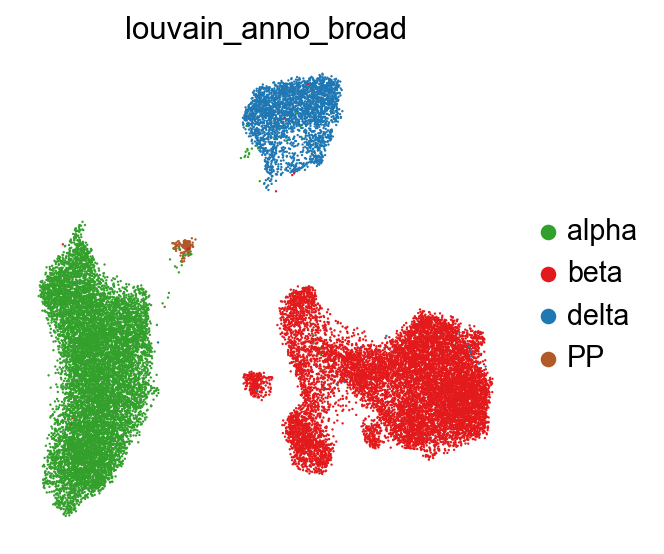

In [6]:
sc.pl.umap(adata_endo, color=['louvain_anno_broad'])

findfont: Font family ['Helvetica Light'] not found. Falling back to DejaVu Sans.


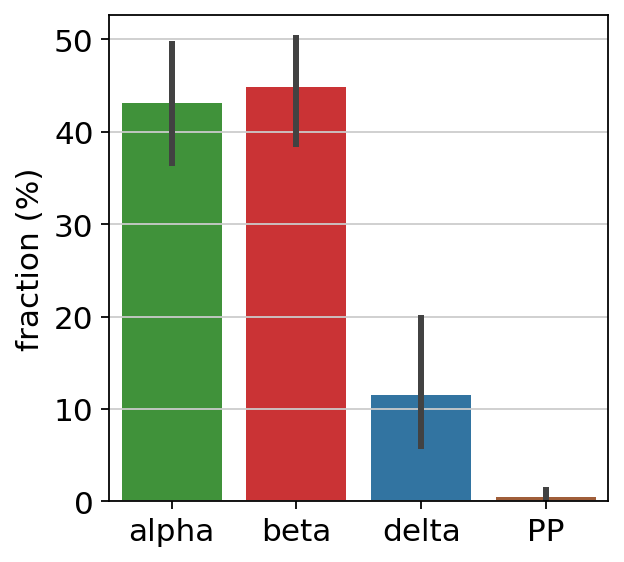

In [7]:
df=adata_endo.obs[['louvain_anno_broad','donor']]
order_cat=['alpha', 'beta', 'delta', 'PP']
pl.subplots()

x='louvain_anno_broad'
y='proportion'
hue='donor'
prop_df = (df[x].groupby(df[hue])
            .value_counts(normalize=True)
            .rename(y)
            .reset_index())

prop_df[y]=prop_df[y]*100

sns.barplot(x='louvain_anno_broad', y=y, data=prop_df,palette=adata_endo.uns['louvain_anno_broad_colors'],order=order_cat,orient='v')
pl.xticks(rotation=0,fontsize=14,fontname='Helvetica Light')
pl.yticks(rotation=0,fontsize=14,fontname='Helvetica Light')

pl.xlabel('')
pl.ylabel('fraction (%)',fontsize=14,fontname='Helvetica Light')
pl.show()

In [110]:
adata_endo.obs.louvain_anno_broad.value_counts()

beta     11923
alpha    11541
delta     2889
PP         121
Name: louvain_anno_broad, dtype: int64

## Marker enrichment

In [52]:
marker_dict_endo=dict()
for group in ['alpha', 'beta', 'delta', 'PP']:

    refs = ['alpha', 'beta', 'delta', 'PP']
    refs.remove(group)
    adata_group = adata_endo[adata_endo.obs.louvain_anno_broad.isin([group])].copy()
    genes_frac = (adata_group.X > 0).sum(0) / adata_group.n_obs

    if group in ['PP']:
        genes = adata_group.var_names[genes_frac.A1>0.1]
    else:
        genes = adata_group.var_names[genes_frac.A1>0.05]
    
    adata_sub=adata_endo[:,genes].copy()
    
    sc.tl.rank_genes_groups(adata_sub,groupby='louvain_anno_broad',method='t-test',n_genes=adata_sub.n_vars)
    df = sc.get.rank_genes_groups_df(adata_sub, group=group).loc[sc.get.rank_genes_groups_df(adata_sub, group=group)['logfoldchanges']>0.5]
    genes = df['names']
    marker_dict_endo[group]=list(genes)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be i

In [53]:
workbook = xlsxwriter.Workbook('./output_files/marker_dict_endo_enriched.xlsx')

worksheet = workbook.add_worksheet()

row = 0
col = 0

for key in marker_dict_endo.keys():
    row = 0
    worksheet.write(row, col, key)
    for item in marker_dict_endo[key]:
        worksheet.write(row+1, col, item)
        row += 1
    col += 1
workbook.close()

## Islet transcription factors

In [82]:
genes=['NEUROD1', 'NKX2-2', 'FOXA2', 'FOXO1', 'PAX6', 'ISL1', 'RFX6', 'GCG', 'ARX', 'PPY',
       'MAFB', 'INS', 'IAPP',  'MAFA', 'MNX1', 'NKX6-1', 'TSHZ1', 'PDX1', 'SST', 'HHEX']

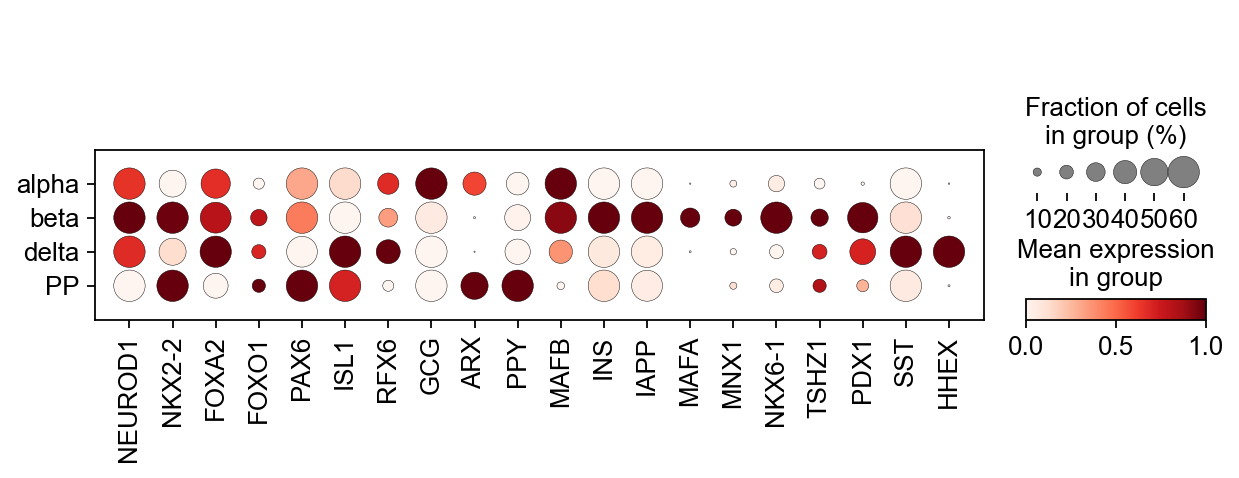

In [84]:
sc.pl.dotplot(adata_endo, groupby='louvain_anno_broad', var_names=genes, standard_scale='var', dot_max=0.6)

## MHC signature

In [21]:
mk_human = pd.read_excel('./output_files/gene_sets_beta.xlsx')

In [23]:
sc.tl.score_genes(adata_endo, gene_list=mk_human[9].dropna().tolist(), score_name='MHC_geneset_score')

computing score 'MHC_geneset_score'
    finished: added
    'MHC_geneset_score', score of gene set (adata.obs).
    297 total control genes are used. (0:00:29)


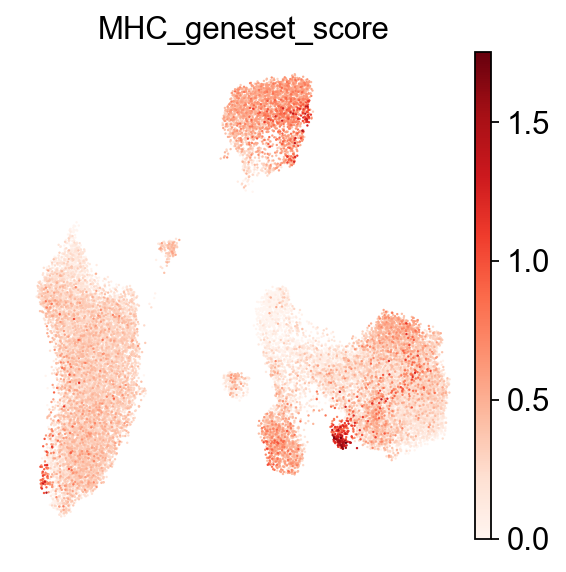

In [26]:
sc.pl.umap(adata_endo, color=['MHC_geneset_score'], color_map='Reds', vmin=0)